In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

# Загрузка данных

In [9]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])

# Baseline

In [10]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))

In [11]:
clf=xgb.XGBClassifier()
get_score(clf,X,y)

CVScore: 0.539320315139
HoldOut: 0.557784145177


# Подбор параметров

In [100]:
def score(params):
    print ("Training with params : ")
    print (params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    #predictions = model.predict(dvalid).reshape((X_test.shape[0], 5))
    predictions = model.predict(dvalid)
    score = accuracy_score(y_test, predictions)
    print ("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             #'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'num_class': 5,
             'eval_metric': 'mlogloss',
             'objective': 'multi:softmax',
             'nthread' : 6,
             'silent' : 1
             }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print (best)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Trials object where the history of search will be stored
trials = Trials()

In [104]:
optimize(trials)

Training with params : 
{'min_child_weight': 1.0, 'n_estimators': 920.0, 'silent': 1, 'nthread': 6, 'gamma': 0.8, 'max_depth': 1, 'eta': 0.025, 'subsample': 0.6000000000000001, 'num_class': 5, 'colsample_bytree': 0.75, 'eval_metric': 'mlogloss', 'objective': 'multi:softmax'}
	Score 0.5673352435530086


Training with params : 
{'min_child_weight': 5.0, 'n_estimators': 693.0, 'silent': 1, 'nthread': 6, 'gamma': 0.9500000000000001, 'max_depth': 7, 'eta': 0.2, 'subsample': 0.75, 'num_class': 5, 'colsample_bytree': 0.7000000000000001, 'eval_metric': 'mlogloss', 'objective': 'multi:softmax'}
	Score 0.5616045845272206


Training with params : 
{'min_child_weight': 2.0, 'n_estimators': 265.0, 'silent': 1, 'nthread': 6, 'gamma': 0.65, 'max_depth': 12, 'eta': 0.05, 'subsample': 0.75, 'num_class': 5, 'colsample_bytree': 0.55, 'eval_metric': 'mlogloss', 'objective': 'multi:softmax'}
	Score 0.5558739255014327


Training with params : 
{'min_child_weight': 2.0, 'n_estimators': 215.0, 'silent': 1, 'n

# Сравнение нескольких моделей

In [109]:
print ('baseline')
clf=xgb.XGBClassifier(seed=42)
get_score(clf,X,y)
print ('best_Hyperopt')
clf=xgb.XGBClassifier(max_depth=9,colsample_bytree=0.8,min_child_weight=2.0,n_estimators=326,gamma=0.8,subsample=0.5)
get_score(clf,X,y)

baseline
CVScore: 0.539320315139
HoldOut: 0.557784145177
best_Hyperopt
CVScore: 0.535206751254
HoldOut: 0.550143266476


In [103]:
score

<function __main__.score>

In [97]:
score = accuracy_score(y_test, pred)
score

0.57975167144221584

## 2. Подбираем max_depth и min_child_weight

In [71]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60)
param_test = {
 'max_depth':[9,11,13],
 'min_child_weight':[5,9,11]
}
#'min_data_in_leaf':np.arange(20,1001,50)
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.8min finished


{'max_depth': 9, 'min_child_weight': 5}

## 3. Подбираем subsample and colsample_bytree

In [78]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60,max_depth=9,min_child_weight=5,subsample=0.8)
param_test = {
 'colsample_bytree':[i/100.0 for i in range(10,40,10)]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_
gbm.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [79]:
estimator = lgb.LGBMClassifier(learning_rate=0.08,n_estimators=60,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2)
param_test = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   34.3s finished


{'reg_alpha': 1e-05}

In [80]:
estimator = lgb.LGBMClassifier(learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)
param_test = {
 'n_estimators':[1000, 1500,2000,3000,5000]
}
gbm = GridSearchCV(estimator,param_grid=param_test,cv=5,verbose=True)
gbm.fit(X, y)
gbm.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 20.5min finished


{'n_estimators': 1500}

# Лучшая модель

In [5]:
estimator = lgb.LGBMClassifier(n_estimators=1500,learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)

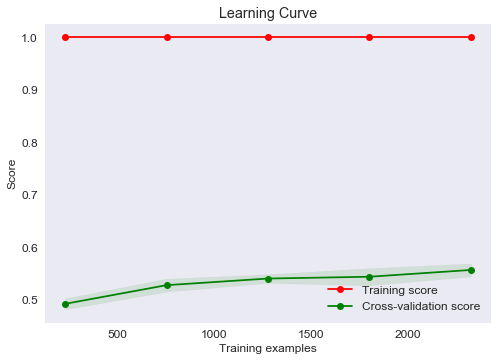

In [10]:
from scikitplot import plotters as skplt
skplt.plot_learning_curve(estimator, X, y)
plt.show()

# feature importances

In [ ]:
cf1= classifier_factory(clf)
cf1.fit(X_train, y_train)
cf1.plot_feature_importances(feature_names=X.columns)
plt.show()

In [116]:
ftr_set=['f11', 'f96', 'f138', 'f156', 'f76', 'f131', 'f185', 'f45'] 
clf = lgb.LGBMClassifier(learning_rate=0.01,max_depth=9,min_child_weight=5,subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)
cv_score = cross_val_score(clf, X[ftr_set], y, cv=5).mean()
print (cv_score)

0.492375853059


# 25 - 50 - 75 % fi

In [25]:
def get_score(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    print ("CVScore:",cv_score)
    clf.fit(X_train,y_train)
    print ("HoldOut:",clf.score(X_test,y_test))

In [26]:
clf = lgb.LGBMClassifier(n_estimators=1500,learning_rate=0.01,max_depth=9,min_child_weight=5,
                               subsample=0.8,colsample_bytree=0.2,reg_alpha=1e-05)

In [4]:

clf.fit(X,y)
fi=clf.feature_importances_

In [5]:
fi_pf=pd.DataFrame(data=fi,columns=['fi_rank'],index=X.columns)
fi_pf=fi_pf.sort_values(['fi_rank'],ascending=False)
fi_pf['rank']=0
for i in range (fi_pf.shape[0]):
    fi_pf.iloc[i,1]=i
fi_pf.head()

,fi_rank,rank
f11,0.012249,0
f96,0.009489,1
f156,0.008735,2
f21,0.008296,3
f173,0.008098,4


In [6]:
def get_first_ftr(N):
    ftrN=fi_pf[fi_pf['rank']<N].index
    return list(ftrN)

In [27]:
get_score(clf,X,y)

CVScore: 0.559776172449
HoldOut: 0.574021012416


In [18]:
ftr25=get_first_ftr(int(len(X.columns)*0.25))
ftr50=get_first_ftr(int(len(X.columns)*0.5))
ftr75=get_first_ftr(int(len(X.columns)*0.75))

In [19]:
get_score(clf,X[ftr25],y)

CVScore: 0.529059962353
HoldOut: 0.550143266476


In [20]:
get_score(clf,X[ftr50],y)


CVScore: 0.535621660877
HoldOut: 0.567335243553


In [21]:
get_score(clf,X[ftr75],y)

CVScore: 0.548736580275
HoldOut: 0.573065902579
